This notebook provides recipes for loading and saving data from external sources.

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import os


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [25]:
# KATEGORIE ODPADÓW
carb = '/content/drive/MyDrive/cardboard'
glass ="/content/drive/MyDrive/glass"
metal ="/content/drive/MyDrive/metal"
paper = "/content/drive/MyDrive/paper"
plastic ="/content/drive/MyDrive/plastic"

In [26]:
import cv2  
import os

X=[]
y_label =[]
imgsize = 150

def train_data(label,data_dir):
    for img in os.listdir(data_dir):
        path = os.path.join(data_dir,img)
        print(path)
        img = cv2.imread(path,1)
        print(img)
        
        img = cv2.resize(img,(imgsize,imgsize))
        X.append(np.array(img))
        y_label.append(str(label))
        

train_data('cardboard',carb)
train_data('class',glass)
train_data('metal',metal)
train_data('paper',paper)
train_data('plastic',plastic)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/plastic/plastic188.jpg
[[[185 158 148]
  [185 158 148]
  [185 158 148]
  ...
  [149 129 118]
  [149 129 118]
  [149 129 118]]

 [[185 158 148]
  [185 158 148]
  [184 157 147]
  ...
  [149 129 118]
  [149 129 118]
  [149 129 118]]

 [[184 157 147]
  [184 157 147]
  [184 157 147]
  ...
  [149 129 118]
  [149 129 118]
  [149 129 118]]

 ...

 [[172 151 136]
  [172 151 136]
  [170 149 134]
  ...
  [179 151 134]
  [177 151 134]
  [177 151 134]]

 [[174 153 138]
  [174 153 138]
  [172 151 136]
  ...
  [179 151 134]
  [177 151 134]
  [177 151 134]]

 [[173 152 137]
  [173 152 137]
  [172 151 136]
  ...
  [179 151 134]
  [177 151 134]
  [177 151 134]]]
/content/drive/MyDrive/plastic/plastic189.jpg
[[[196 171 161]
  [196 171 161]
  [196 171 161]
  ...
  [192 166 154]
  [192 166 154]
  [192 166 154]]

 [[196 171 161]
  [196 171 161]
  [196 171 161]
  ...
  [192 166 154]
  [192 166 154]
  [192 166 154]]

 [[196 171 161]
  [

In [27]:
from sklearn.preprocessing import LabelEncoder  

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label)   
X = np.array(X) 
X = X/255 

In [28]:
y = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()

y = y.astype(np.float32)

print("y.shape: ", y.shape)
print("X.shape: ", X.shape)

y.shape:  (2390, 5)
X.shape:  (2390, 150, 150, 3)


In [29]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state =0)

In [43]:
def create_cnn_model(_input_shape, _conv_num, _dense_num, _act, _output_num):
    # pusty model sekwyncyjny
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=_input_shape))
    # warstwy konowlucyjne+max pool
    for idx, one_conv_filters in enumerate(_conv_num):
        # konowlucje
        model.add(
            layers.Conv2D(
                filters=one_conv_filters,
                kernel_size=3,
                strides=1,
                padding="SAME",
                activation=_act,
                name="konwolucja_"+str(idx)
            )
        )
        # max pool
        model.add(
            layers.MaxPool2D(
                pool_size=2,
                strides=2,
                padding="SAME",
                name="redukcja_"+str(idx)
            )
        )
        # dropout
        model.add(
            layers.Dropout(0.5)
        )
    # spłaszczenie NxHxWxC => NxK, K-ilość wszystkich featerów
    model.add(layers.Flatten(name="splaszczenie"))
    # warstwy gęste
    for idx, one_dense_units in enumerate(_dense_num):
        # dense
        model.add(
            layers.Dense(
                units=one_dense_units,
                activation=_act,
                name="gesta_"+str(idx)
            )
        )
        # # dropout
        model.add(
            layers.Dropout(0.5)
        )
    # warstwa wyjściowa
    model.add(layers.Dense(_output_num, name="wyjscie"))
    # warstwa softmax, tworzy dystrybucję prawdopodobieństwa
    model.add(layers.Softmax())
    # wyświetlenie modelu
    print(model.summary())
    
    # kompilacja modelu
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model

In [44]:
Model_CNN = create_cnn_model(
    _input_shape=X_test.shape[1:],
    _conv_num=[100,300,100],
    _dense_num=[128,512],
    _act="relu",
    _output_num=y_test.shape[1]
)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
konwolucja_0 (Conv2D)        (None, 150, 150, 100)     2800      
_________________________________________________________________
redukcja_0 (MaxPooling2D)    (None, 75, 75, 100)       0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 75, 75, 100)       0         
_________________________________________________________________
konwolucja_1 (Conv2D)        (None, 75, 75, 300)       270300    
_________________________________________________________________
redukcja_1 (MaxPooling2D)    (None, 38, 38, 300)       0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 38, 38, 300)       0         
_________________________________________________________________
konwolucja_2 (Conv2D)        (None, 38, 38, 100)     

In [45]:
history = Model_CNN.fit(
    x=X_train,
    y=y_train,
    batch_size=100,
    epochs=200,
    validation_split=0.05
)

Epoch 1/200
19/19 [==============================] - 7s 319ms/step - loss: 1.8264 - accuracy: 0.2221 - val_loss: 1.6007 - val_accuracy: 0.2188
Epoch 2/200
19/19 [==============================] - 6s 312ms/step - loss: 1.6031 - accuracy: 0.2515 - val_loss: 1.5989 - val_accuracy: 0.2188
Epoch 3/200
19/19 [==============================] - 6s 315ms/step - loss: 1.5978 - accuracy: 0.2551 - val_loss: 1.5980 - val_accuracy: 0.2188
Epoch 4/200
19/19 [==============================] - 6s 318ms/step - loss: 1.5881 - accuracy: 0.2464 - val_loss: 1.5673 - val_accuracy: 0.2188
Epoch 5/200
19/19 [==============================] - 6s 313ms/step - loss: 1.5691 - accuracy: 0.2552 - val_loss: 1.6136 - val_accuracy: 0.2188
Epoch 6/200
19/19 [==============================] - 6s 309ms/step - loss: 1.5574 - accuracy: 0.2520 - val_loss: 1.5174 - val_accuracy: 0.3438
Epoch 7/200
19/19 [==============================] - 6s 306ms/step - loss: 1.5235 - accuracy: 0.2713 - val_loss: 1.5324 - val_accuracy: 0.3021

Wyjścia po treningu 10 epok:
[2 4 3 3 1]

Referencyjne wyjścia:
[4 1 3 3 4]


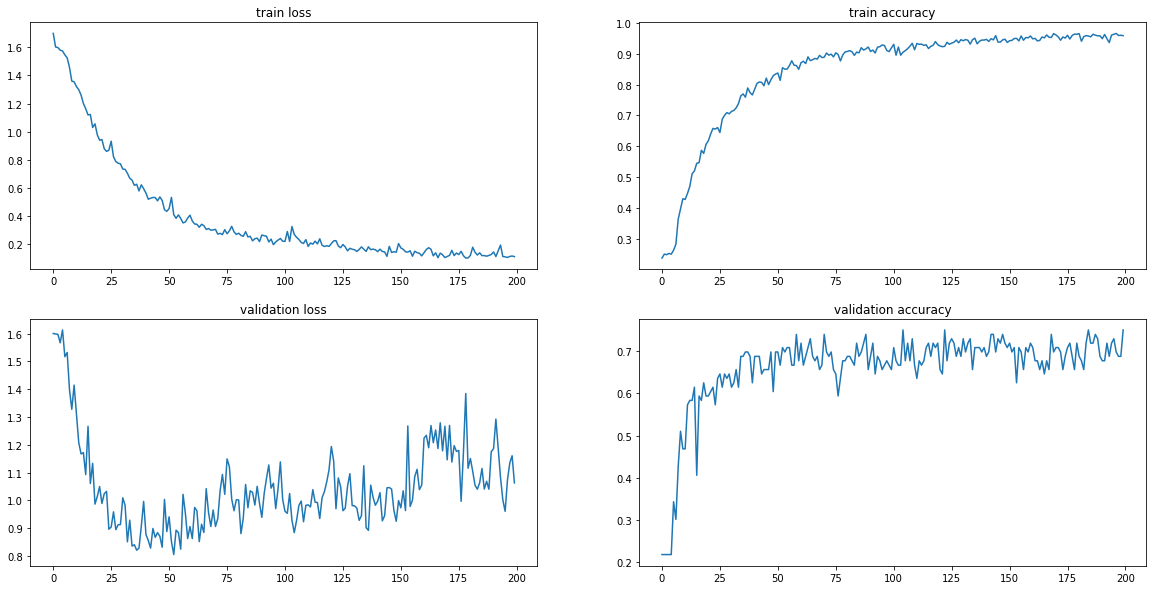

              precision    recall  f1-score   support

           0       0.84      0.85      0.84        78
           1       0.63      0.52      0.57       107
           2       0.61      0.59      0.60        86
           3       0.77      0.81      0.79       114
           4       0.58      0.67      0.62        93

    accuracy                           0.68       478
   macro avg       0.68      0.69      0.68       478
weighted avg       0.68      0.68      0.68       478

[[66  2  4  3  3]
 [ 5 56 17  8 21]
 [ 2 16 51  7 10]
 [ 4  2  5 92 11]
 [ 2 13  7  9 62]]


In [46]:
print("Wyjścia po treningu {0} epok:\n{1}\n\nReferencyjne wyjścia:\n{2}".format(
    10, 
    Model_CNN.predict(X_test[:5]).argmax(axis=1), 
    y_test[:5].argmax(axis=1)))

# wykresy porównujące jakość modelu na treningu i walidacji
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

# testowanie
y_pred = Model_CNN.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

IntSlider(value=1, description='Select a photo:', max=506, min=1, orientation='vertical')

Button(description='SELECT', style=ButtonStyle())

291
metal
Prawdopodobieństwo:" 91.58%, Predykcja: metal


<Figure size 432x288 with 0 Axes>

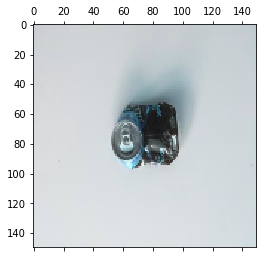

In [48]:
#Widget do rozpoznawania odpadów

import ipywidgets as widgets
from IPython.display import display


w = slider_widget = widgets.IntSlider(
    min=1,
    max=506,
    step=1,
    description='Select a photo:',
    orientation='vertical')

display(w)

run_button = widgets.Button(description="SELECT") 
def button_callback(button):
    print(w.value)
    plt.gray()
    plt.matshow(X_test[w.value])
    label = {0: "karton", 1:"szkło", 2: "metal", 3: "papier", 4:"plastik"}
    for i in range(5):
      if np.argmax(y_test[w.value]) == i:
        print(label[i])
        y_pred = Model_CNN.predict(X_test[w.value].reshape(-1,150,150,3))
        p = y_pred.max()
        pozycja = np.argmax(y_pred, axis=None)
        print('Prawdopodobieństwo:" {:.2%}, Predykcja: {}'.format(p, label[pozycja]))

run_button.on_click(button_callback)

display(run_button)